# Classifying IMDB reviews data (Embedding + MLP + Conv1D)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\Himanshu\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [44]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [45]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [46]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [36]:
model_emb = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_emb.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_emb.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_3 (Flatten)         (None, 1920)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               245888    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 406,017
Trainable params: 406,017
Non-trainable params: 0
_________________________________________________________________


In [37]:
num_epochs = 10
history_emb = model_emb.fit(padded, training_labels_finals, epochs=num_epochs, validation_data=(testing_padded, testing_labels_finals))

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4560 - accuracy: 0.7713 - val_loss: 1.2997 - val_accuracy: 0.5017
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2009 - accuracy: 0.9239 - val_loss: 1.7957 - val_accuracy: 0.5040
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0406 - accuracy: 0.9882 - val_loss: 2.9309 - val_accuracy: 0.5018
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 3.9431 - val_accuracy: 0.5010
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 7.5109e-04 - accuracy: 1.0000 - val_loss: 4.3378 - val_accuracy: 0.5009
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 1.9406e-04 - accuracy: 1.0000 - val_loss: 4.6188 - val_accuracy: 0.5020
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 1.0430e-04 - accuracy: 1.0000 - val_loss: 4.8616 - val_accuracy: 0

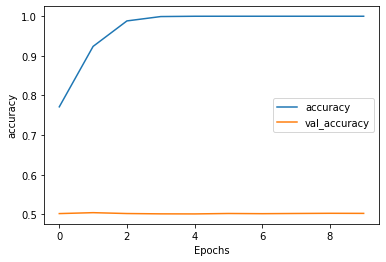

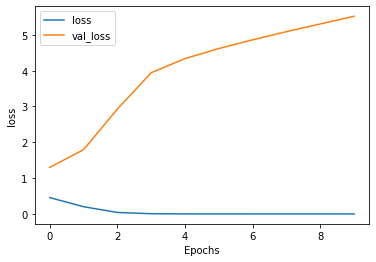

In [38]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_emb, 'accuracy')
plot_graphs(history_emb, 'loss')

In [39]:
e = model_emb.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [40]:
# USE this if you want to see the spatial data in 3D
# import io

# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(1, vocab_size):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [41]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)
padded = pad_sequences(sequence,maxlen=max_length, truncating=trunc_type)
print(model_emb.predict(padded))

[[11], [], [1431], [966], [4], [1537], [1537], [4715], [], [790], [2019], [11], [2929], [2184], [], [790], [2019], [11], [579], [], [11], [579], [], [4], [1782], [4], [4517], [11], [2929], [1275], [], [], [2019], [1003], [2929], [966], [579], [790], []]
[[0.07263432]
 [0.08326153]
 [0.5183469 ]
 [0.10024267]
 [0.08368837]
 [0.0890218 ]
 [0.0890218 ]
 [0.06894181]
 [0.08326153]
 [0.08800982]
 [0.09592239]
 [0.07263432]
 [0.08211993]
 [0.02958331]
 [0.08326153]
 [0.08800982]
 [0.09592239]
 [0.07263432]
 [0.04434799]
 [0.08326153]
 [0.07263432]
 [0.04434799]
 [0.08326153]
 [0.08368837]
 [0.04565082]
 [0.08368837]
 [0.06341709]
 [0.07263432]
 [0.08211993]
 [0.1518694 ]
 [0.08326153]
 [0.08326153]
 [0.09592237]
 [0.13315973]
 [0.08211991]
 [0.10024267]
 [0.04434802]
 [0.08800982]
 [0.08326153]]


## Using (Embedding + Conv1D)

In [47]:
# Model Definition with Conv1D
model_conv1d = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_conv1d.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_conv1d.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 6)                 774       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [48]:
num_epochs = 10
history_conv1d = model_conv1d.fit(padded, training_labels_finals, epochs=num_epochs, validation_data=(testing_padded, testing_labels_finals))

Epoch 1/10
782/782 [==============================] - 11s 7ms/step - loss: 0.5466 - accuracy: 0.7532 - val_loss: 0.9339 - val_accuracy: 0.5014
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3675 - accuracy: 0.8784 - val_loss: 1.1449 - val_accuracy: 0.5017
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2875 - accuracy: 0.9061 - val_loss: 1.2731 - val_accuracy: 0.5022
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2361 - accuracy: 0.9258 - val_loss: 1.6369 - val_accuracy: 0.5025
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1987 - accuracy: 0.9392 - val_loss: 1.8546 - val_accuracy: 0.5018
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 0.1698 - accuracy: 0.9502 - val_loss: 2.0314 - val_accuracy: 0.5013
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1481 - accuracy: 0.9590 - val_loss: 2.5776 - val_accuracy: 0.5019
Epoch

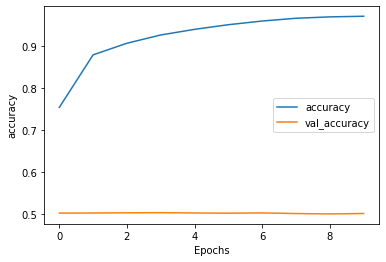

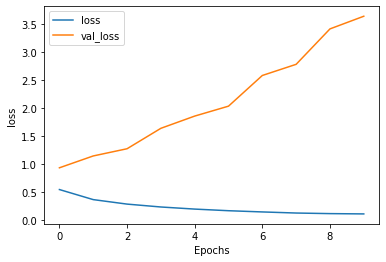

In [49]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_conv1d, 'accuracy')
plot_graphs(history_conv1d, 'loss')

### Exploring Model Definition

In [50]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_14 (Dense)            (None, 6)                 390       
                                                                 
 dense_15 (Dense)            (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Model Definition with GRU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 6)                 390       
                                                                 
 dense_17 (Dense)            (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_3 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 6)                 774       
                                                                 
 dense_19 (Dense)            (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________